<h1> Home Loan Prediction </h1>

In [113]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set()

In [114]:
df = pd.read_csv('data/loantrain.csv')

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


In [116]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [117]:
#Correct columns name inconsistences 
df = df.rename(columns={'Loan_ID': 'LoanID', 'Self_Employed': 'SelfEmployed', 'Loan_Amount_Term': 'LoanAmountTerm', 'Credit_History': 'CreditHistory', 'Property_Area': 'PropertyArea', 'Loan_Status': 'LoanStatus'})

In [118]:
df.nunique()

LoanID               614
Gender                 2
Married                2
Dependents             4
Education              2
SelfEmployed           2
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           203
LoanAmountTerm        10
CreditHistory          2
PropertyArea           3
LoanStatus             2
dtype: int64

In [119]:
#Summary of the variables containing numerical values
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [120]:
df.isnull().sum()

LoanID                0
Gender               13
Married               3
Dependents           15
Education             0
SelfEmployed         32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
LoanAmountTerm       14
CreditHistory        50
PropertyArea          0
LoanStatus            0
dtype: int64

In [121]:
df[df['SelfEmployed'].isnull()][df['ApplicantIncome']>5000]

C:\Users\sirro\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,LoanID,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,PropertyArea,LoanStatus
95,LP001326,Male,No,0,Graduate,NaN,6782,0.0,NaN,360.0,NaN,Urban,N
107,LP001370,Male,No,0,Not Graduate,NaN,7333,0.0,120.0,360.0,1.0,Rural,N
114,LP001398,Male,No,0,Graduate,NaN,5050,0.0,118.0,360.0,1.0,Semiurban,Y
236,LP001786,Male,Yes,0,Graduate,NaN,5746,0.0,255.0,360.0,NaN,Urban,N
333,LP002101,Male,Yes,0,Graduate,NaN,63337,0.0,490.0,180.0,1.0,Urban,Y
336,LP002110,Male,Yes,1,Graduate,NaN,5250,688.0,160.0,360.0,1.0,Rural,Y
411,LP002319,Male,Yes,0,Graduate,NaN,6256,0.0,160.0,360.0,NaN,Urban,Y
432,LP002386,Male,No,0,Graduate,NaN,12876,0.0,405.0,360.0,1.0,Semiurban,Y
463,LP002489,Female,No,1,Not Graduate,NaN,5191,0.0,132.0,360.0,1.0,Semiurban,Y


Two of the applicant's income was over 10,000 and they live in the Urban and Semiurban areas therefore it is quite likely that they are selfemployed. One applicant lives in the rural area, he doesn't have a higher education and has an income of 7,333 may possible be selfemployed.  

In [123]:
df.iloc[107, 5] = 'Yes'
df.iloc[333, 5] = 'Yes'
df.iloc[432, 5] = 'Yes'

In [124]:
df.isnull().sum()

LoanID                0
Gender               13
Married               3
Dependents           15
Education             0
SelfEmployed         29
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
LoanAmountTerm       14
CreditHistory        50
PropertyArea          0
LoanStatus            0
dtype: int64

In [125]:
#Replace missing values in SelfEmployed column
df['SelfEmployed'].fillna('No', inplace=True)

In [126]:
df['LoanAmountTerm'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: LoanAmountTerm, dtype: int64

In [127]:
#Replace missing values in LoanAmountTerm column
df['LoanAmountTerm'].fillna(360, inplace=True)

In [128]:
#Number of ApplicantIncome below $10,0000
df[df['ApplicantIncome'] < 10000].shape

(559, 13)

In [129]:
#Number of CoapplicantIncome below $10,0000
df[df['CoapplicantIncome'] < 10000].shape

(608, 13)

In [130]:
#Drop row with missing data for Dependents and Loan amount
df2 = df.dropna(subset=['Dependents', 'LoanAmount'])

#Replace value
df2 = df2.replace(to_replace='3+',value='3')

#Change data type to int for dependents
df2.loc[:, 'Dependents'] = df2['Dependents'].astype(int)

In [131]:
#Summary of the variables containing numerical values after addressing some missing values. 
df2.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory
count,579.000000,579.000000,579.000000,579.000000,579.000000,530.000000
mean,0.761658,5432.177893,1651.635440,146.816926,342.072539,0.849057
std,1.014692,6228.236981,2992.599435,86.343049,64.546233,0.358332
min,0.000000,150.000000,0.000000,9.000000,12.000000,0.000000
25%,0.000000,2879.000000,0.000000,100.000000,360.000000,1.000000
50%,0.000000,3775.000000,1229.000000,128.000000,360.000000,1.000000
75%,2.000000,5816.500000,2318.000000,169.000000,360.000000,1.000000
max,3.000000,81000.000000,41667.000000,700.000000,480.000000,1.000000


In [132]:
#Percent differences between the original data set and the updated
(df.describe() - df2.describe())/df.describe()*100

,ApplicantIncome,CoapplicantIncome,CreditHistory,Dependents,LoanAmount,LoanAmountTerm
count,5.700326,5.700326,6.028369,NaN,2.195946,5.700326
mean,-0.531486,-1.874462,-0.814300,NaN,-0.276455,0.098678
std,-1.951129,-2.267445,1.794136,NaN,-0.882986,-0.182534
min,0.000000,NaN,NaN,NaN,0.000000,0.000000
25%,-0.052129,NaN,0.000000,NaN,0.000000,0.000000
50%,0.983607,-3.407657,0.000000,NaN,0.000000,0.000000
75%,-0.371009,-0.903254,0.000000,NaN,-0.595238,0.000000
max,0.000000,0.000000,0.000000,NaN,0.000000,0.000000


In [133]:
#Add TotalIncome column
df2['TotalIncome'] = df2['ApplicantIncome'] + df2['CoapplicantIncome']

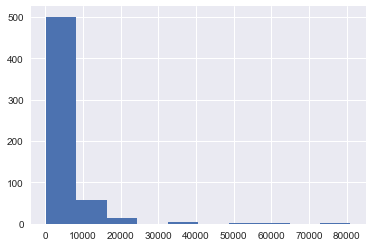

In [134]:
#Distribution of Income
plt.hist(df2['ApplicantIncome'])
plt.show()

In [135]:
#Explore Income Above $20,000
df2[df2['ApplicantIncome'] > 20000]

,LoanID,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,PropertyArea,LoanStatus,TotalIncome
126,LP001448,NaN,Yes,3,Graduate,No,23803,0.0,370.0,360.0,1.0,Rural,Y,23803.0
130,LP001469,Male,No,0,Graduate,Yes,20166,0.0,650.0,480.0,NaN,Urban,Y,20166.0
155,LP001536,Male,Yes,3,Graduate,No,39999,0.0,600.0,180.0,0.0,Semiurban,Y,39999.0
171,LP001585,NaN,Yes,3,Graduate,No,51763,0.0,700.0,300.0,1.0,Urban,Y,51763.0
183,LP001637,Male,Yes,1,Graduate,No,33846,0.0,260.0,360.0,1.0,Semiurban,N,33846.0
185,LP001640,Male,Yes,0,Graduate,Yes,39147,4750.0,120.0,360.0,1.0,Semiurban,Y,43897.0
308,LP001996,Male,No,0,Graduate,No,20233,0.0,480.0,360.0,1.0,Rural,N,20233.0
333,LP002101,Male,Yes,0,Graduate,Yes,63337,0.0,490.0,180.0,1.0,Urban,Y,63337.0
409,LP002317,Male,Yes,3,Graduate,No,81000,0.0,360.0,360.0,0.0,Rural,N,81000.0
443,LP002422,Male,No,1,Graduate,No,37719,0.0,152.0,360.0,1.0,Semiurban,Y,37719.0


The LoanID LP002317 and LP001448 had a similar application with incomes of 81,000 and 23,803. LP002317 was denied a loan therefore 81,000 could possibly be an outlier that can be safety be removed. 

In [136]:
df3 = df2[df2['ApplicantIncome'] < 80000]

In [137]:
df3.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,TotalIncome
count,578.000000,578.000000,578.000000,578.000000,578.000000,529.000000,578.000000
mean,0.757785,5301.437716,1654.492941,146.448097,342.041522,0.850662,6955.930657
std,1.011280,5379.978522,2994.400863,85.960119,64.597823,0.356759,5834.682216
min,0.000000,150.000000,0.000000,9.000000,12.000000,0.000000,1442.000000
25%,0.000000,2877.500000,0.000000,100.000000,360.000000,1.000000,4166.000000
50%,0.000000,3768.500000,1239.500000,127.500000,360.000000,1.000000,5416.500000
75%,2.000000,5811.250000,2324.000000,168.000000,360.000000,1.000000,7541.750000
max,3.000000,63337.000000,41667.000000,700.000000,480.000000,1.000000,63337.000000


In [138]:
#Calculate the minimum monthly payment with no interest and loan income ratio columns
df3['MonthlyPaymentNoInterest'] = df3['LoanAmount']*1000 / df3['LoanAmountTerm']
df3['LoanToIncomeRatio'] = df3['MonthlyPaymentNoInterest'] / df3['TotalIncome']
df3.head(10)

C:\Users\sirro\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\sirro\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,LoanID,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,PropertyArea,LoanStatus,TotalIncome,MonthlyPaymentNoInterest,LoanToIncomeRatio
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,6091.0,355.555556,0.058374
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,3000.0,183.333333,0.061111
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4941.0,333.333333,0.067463
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,6000.0,391.666667,0.065278
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,9613.0,741.666667,0.077152
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y,3849.0,263.888889,0.068560
7,LP001014,Male,Yes,3,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N,5540.0,438.888889,0.079222
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y,5532.0,466.666667,0.084358
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N,23809.0,969.444444,0.040718
10,LP001024,Male,Yes,2,Graduate,No,3200,700.0,70.0,360.0,1.0,Urban,Y,3900.0,194.444444,0.049858


In [139]:
df3.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,TotalIncome,MonthlyPaymentNoInterest,LoanToIncomeRatio
count,578.000000,578.000000,578.000000,578.000000,578.000000,529.000000,578.000000,578.000000,578.000000
mean,0.757785,5301.437716,1654.492941,146.448097,342.041522,0.850662,6955.930657,478.172063,0.077362
std,1.011280,5379.978522,2994.400863,85.960119,64.597823,0.356759,5834.682216,525.156117,0.080688
min,0.000000,150.000000,0.000000,9.000000,12.000000,0.000000,1442.000000,25.000000,0.007008
25%,0.000000,2877.500000,0.000000,100.000000,360.000000,1.000000,4166.000000,283.333333,0.055512
50%,0.000000,3768.500000,1239.500000,127.500000,360.000000,1.000000,5416.500000,362.500000,0.068970
75%,2.000000,5811.250000,2324.000000,168.000000,360.000000,1.000000,7541.750000,511.111111,0.081666
max,3.000000,63337.000000,41667.000000,700.000000,480.000000,1.000000,63337.000000,9250.000000,1.236873


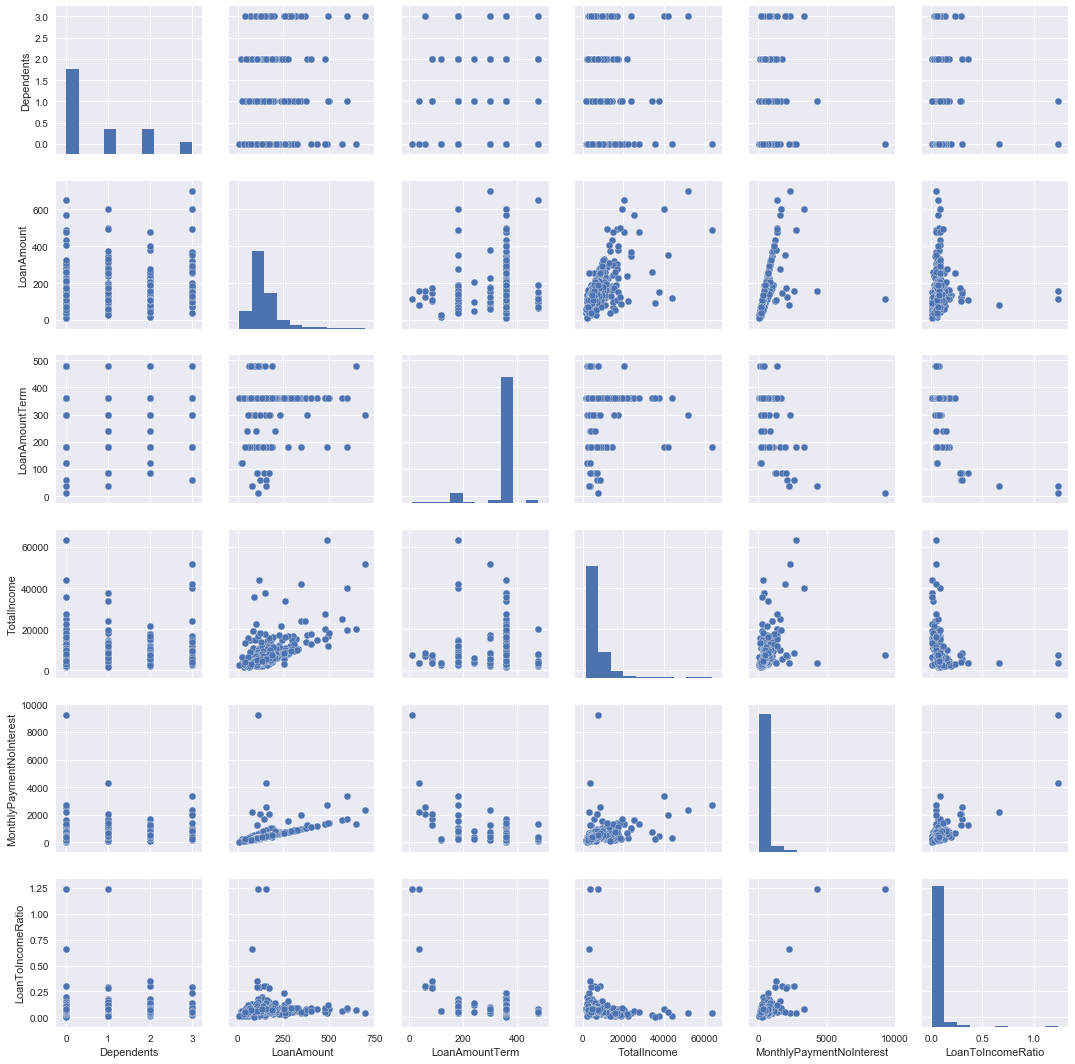

In [140]:
sns.pairplot(df3[['Dependents','LoanAmount','LoanAmountTerm','TotalIncome','MonthlyPaymentNoInterest','LoanToIncomeRatio']])
plt.show()

In [141]:
approved = df3[df3['LoanStatus'] == 'Y']
denied = df3[df3['LoanStatus'] == 'N']

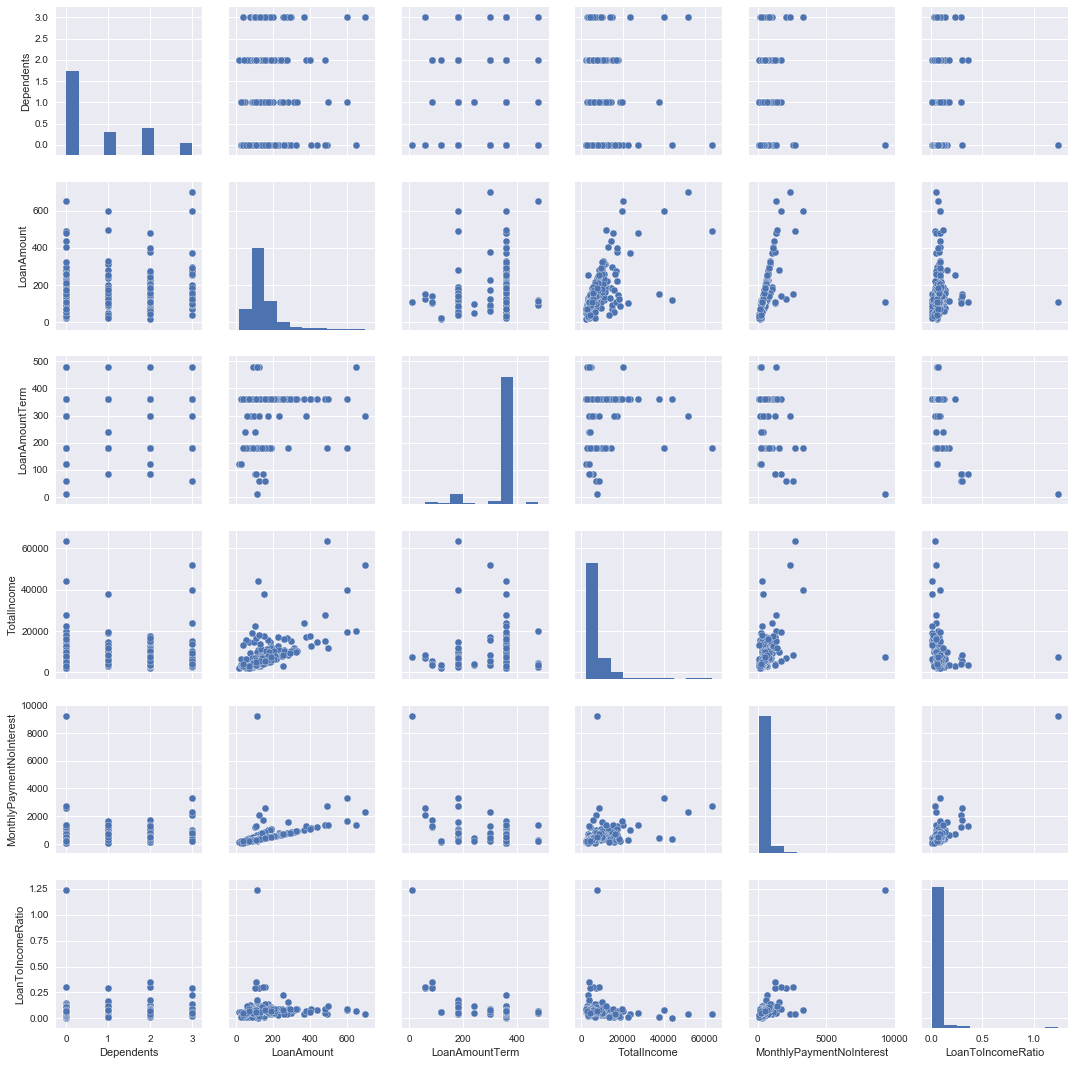

In [142]:
sns.pairplot(approved[['Dependents','LoanAmount','LoanAmountTerm','TotalIncome','MonthlyPaymentNoInterest','LoanToIncomeRatio']])
plt.show()

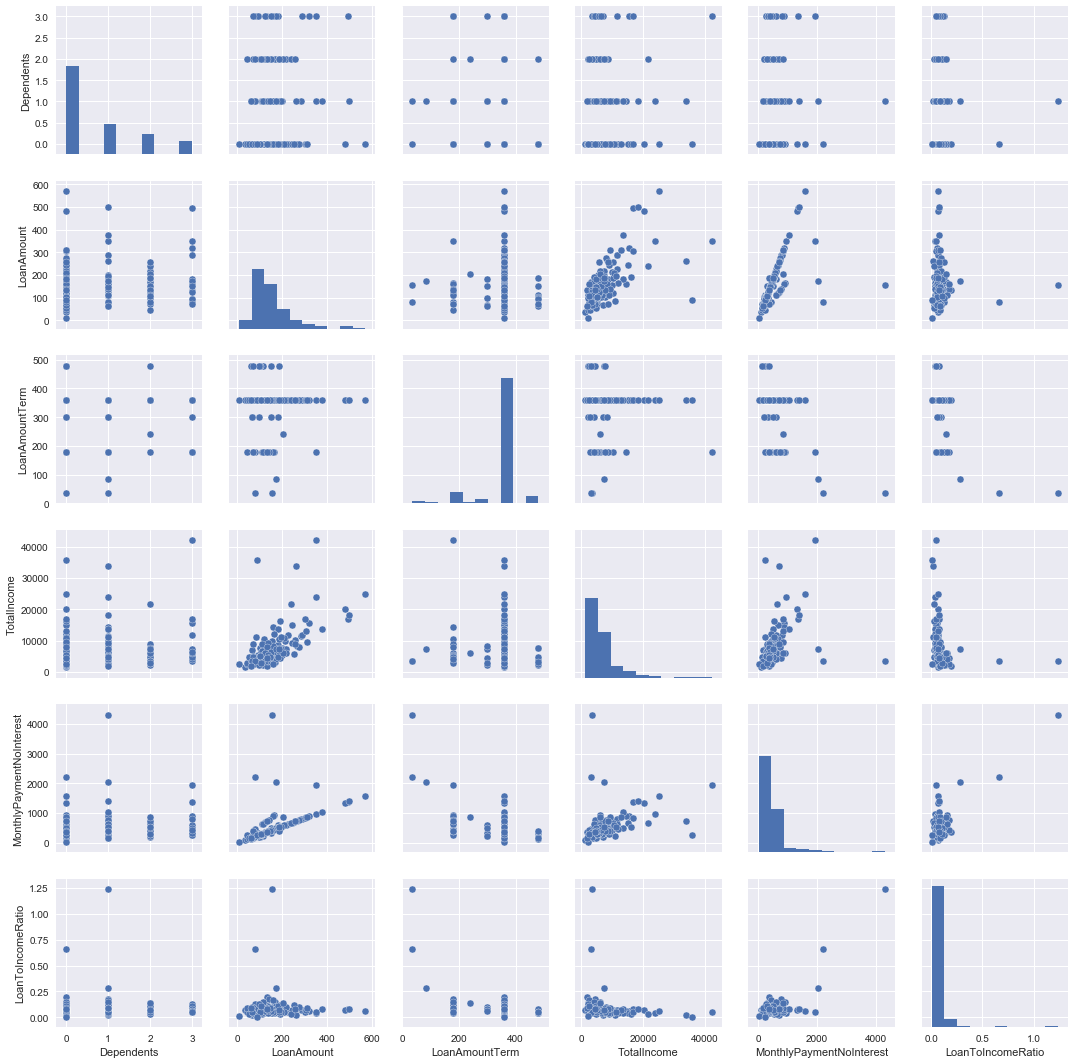

In [143]:
sns.pairplot(denied[['Dependents','LoanAmount','LoanAmountTerm','TotalIncome','MonthlyPaymentNoInterest','LoanToIncomeRatio']])
plt.show()

In [144]:
approved_cleaned = approved[approved['MonthlyPaymentNoInterest'] < 5000]

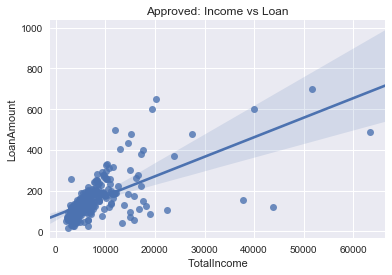

In [145]:
sns.regplot(approved_cleaned['TotalIncome'], approved_cleaned['LoanAmount'])
plt.title('Approved: Income vs Loan')
plt.show()

In [146]:
m, b, r, p, s = stats.linregress(approved_cleaned['TotalIncome'], approved_cleaned['LoanAmount'])
print('The correlation coefficient of our observed data is r =', round(r,3), 'and the p-value is p =', p)

The correlation coefficient of our observed data is r = 0.657 and the p-value is p = 4.696615306254406e-51


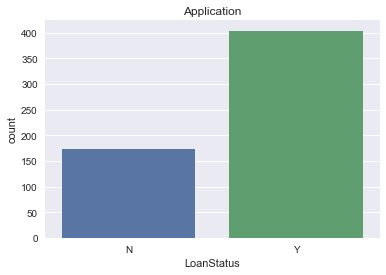

In [147]:
loanstatus = sns.countplot(x='LoanStatus', data =df3)
plt.title('Application')
plt.show()

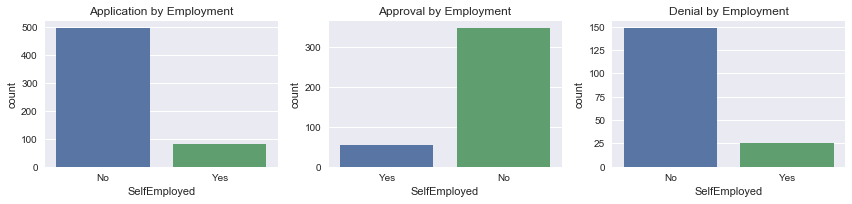

In [175]:
plt.figure(figsize=(12,3))

plt.subplot(1,3,1)
sns.countplot(x='SelfEmployed', data =df3)
plt.title('Application by Employment')

plt.subplot(1,3,2)
sns.countplot(x='SelfEmployed', data =approved)
plt.title('Approval by Employment')

plt.subplot(1,3,3)
sns.countplot(x='SelfEmployed', data =denied)
plt.title('Denial by Employment')

plt.tight_layout()
plt.show()

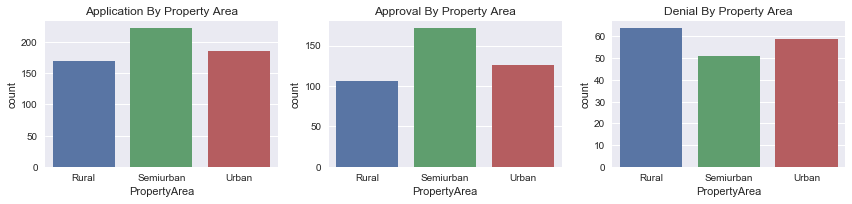

In [176]:
plt.figure(figsize=(12,3))

plt.subplot(1,3,1)
sns.countplot(x='PropertyArea', data =df3, order=('Rural','Semiurban','Urban'))
plt.title('Application By Property Area')

plt.subplot(1,3,2)
sns.countplot(x='PropertyArea', data =approved, order=('Rural','Semiurban','Urban'))
plt.title('Approval By Property Area')

plt.subplot(1,3,3)
sns.countplot(x='PropertyArea', data =denied, order=('Rural','Semiurban','Urban'))
plt.title('Denial By Property Area')

plt.tight_layout()
plt.show()

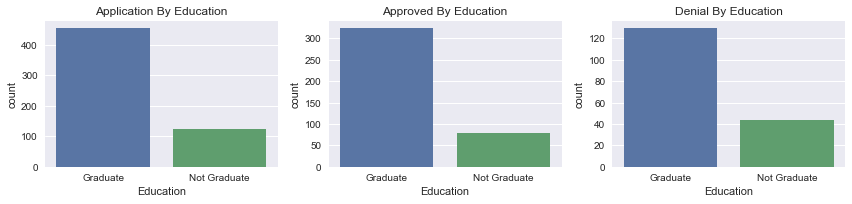

In [177]:
plt.figure(figsize=(12,3))

plt.subplot(1,3,1)
sns.countplot(x=df3['Education'])
plt.title('Application By Education')

plt.subplot(1,3,2)
sns.countplot(x='Education', data =approved)
plt.title('Approved By Education')

plt.subplot(1,3,3)
sns.countplot(x='Education', data =denied)
plt.title('Denial By Education')

plt.tight_layout()
plt.show()

In [151]:
df3.groupby(['PropertyArea','LoanStatus']).size().groupby(level=[0]).apply(lambda x: x / x.sum())

PropertyArea  LoanStatus
Rural         N             0.376471
              Y             0.623529
Semiurban     N             0.228700
              Y             0.771300
Urban         N             0.318919
              Y             0.681081
dtype: float64

In [152]:
df3.groupby(['Education','LoanStatus']).size().groupby(level=[0]).apply(lambda x: x / x.sum())

Education     LoanStatus
Graduate      N             0.285714
              Y             0.714286
Not Graduate  N             0.357724
              Y             0.642276
dtype: float64

In [153]:
df3.groupby(['SelfEmployed','LoanStatus']).size().groupby(level=[0]).apply(lambda x: x / x.sum())

SelfEmployed  LoanStatus
No            N             0.299197
              Y             0.700803
Yes           N             0.312500
              Y             0.687500
dtype: float64

In [154]:
df3.groupby(['Married','LoanStatus']).size().groupby(level=[0]).apply(lambda x: x / x.sum())

Married  LoanStatus
No       N             0.361386
         Y             0.638614
Yes      N             0.268617
         Y             0.731383
dtype: float64

In [155]:
df3.groupby(['CreditHistory','LoanStatus']).size().groupby(level=[0]).apply(lambda x: x / x.sum())

CreditHistory  LoanStatus
0.0            N             0.911392
               Y             0.088608
1.0            N             0.200000
               Y             0.800000
dtype: float64

In [156]:
df3.groupby(['Gender','LoanStatus']).size().groupby(level=[0]).apply(lambda x: x / x.sum())

Gender  LoanStatus
Female  N             0.327103
        Y             0.672897
Male    N             0.292576
        Y             0.707424
dtype: float64